# Введение
Здесь проведён первичный разведочный анализ данных (EDA) для датасета, посвященного физическим свойствам сплавов железа различного химического состава.
Исследуются: структура данных, полнота, выбросы, корреляции.

In [17]:
%matplotlib inline
import math
import re
from typing import List, Tuple
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from IPython.display import display

# Загрузка и проверка данных
Загружаем файл датасета, проверяем типы данных, память

In [18]:
df = pd.read_parquet("iron_alloys_good.parquet")
# Проверка типов и памяти
print("Размер датафрейма:", df.shape)
print("Типы данных:", df.dtypes)
print("------------------------------")
df.info()

Размер датафрейма: (1392, 116)
Типы данных: iron_alloy_name                                   object
Elastic_Youngs_Tensile_Modulus_psi                 Int32
Elongation_at_Break_                             Float32
Shear_Modulus_psi                                  Int32
Tensile_Strength_Ultimate_UTS_psi                  Int32
                                                  ...   
Density_max_gcm                                  Float32
Resilience_Ultimate_Unit_Rupture_Work_min_MJm    Float32
Resilience_Ultimate_Unit_Rupture_Work_max_MJm    Float32
Resilience_Unit_Modulus_of_Resilience_min_kJm      Int32
Resilience_Unit_Modulus_of_Resilience_max_kJm      Int32
Length: 116, dtype: object
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Columns: 116 entries, iron_alloy_name to Resilience_Unit_Modulus_of_Resilience_max_kJm
dtypes: Float32(76), Int32(39), object(1)
memory usage: 792.6+ KB


Для удобства графического исследования:
1. Разберемся с признаками, где указано max и min значения. Они часто совпадают, поэтому возьмем среднее между ними.
2. Разделим столбцы на те, что отражают химический состав и те, что отражают физические свойства сплавов.

In [19]:
def find_min_max_pairs(columns):
    # Функция ищет пары колонок с min и max значением одной и той же величины
    # prefix: всё до "_min" или "_max"
    # mm: "min" или "max"
    # suffix: всё после min/max
    pattern = re.compile(r"^(?P<prefix>.*)_(?P<mm>min|max)(?:_(?P<suffix>.*))?$")
    pairs = {}

    for col in columns:
        m = pattern.match(col)
        if not m:
            continue

        # Извлекаем части названия
        prefix = m.group("prefix")
        mm = m.group("mm")
        suffix = m.group("suffix")

        # Сохраняем единицы измерения, если они были (хвост после min/max)
        base_key = f"{prefix}_{suffix}" if suffix else prefix

        if base_key not in pairs:
            pairs[base_key] = {}

        pairs[base_key][mm] = col

    complete_pairs = {k: v for k, v in pairs.items() if "min" in v and "max" in v}
    return complete_pairs


def add_avg_columns_for_min_max_pairs(
    df, pairs, avg_suffix: str = "_avg", drop_original: bool = True
):
    # Функция по найденным парам min/max добавляет в датасете новые столбцы со средним
    df_out = df.copy()
    created_columns = []
    to_drop = set()

    for base_key, mm in pairs.items():
        avg_col = f"{base_key}{avg_suffix}"
        min_col = mm["min"]
        max_col = mm["max"]

        df_out[avg_col] = (
            df_out[[min_col, max_col]].apply(pd.to_numeric, errors="coerce").mean(axis=1)
        )
        created_columns.append(avg_col)

        if drop_original:
            to_drop.update([min_col, max_col])

    # Удаляем исходные min/max-колонки
    if drop_original and to_drop:
        existing = [c for c in df_out.columns if c in to_drop]
        if existing:
            df_out.drop(columns=existing, inplace=True)

    return df_out, created_columns


pairs = find_min_max_pairs(df.columns)
df_out, created_columns = add_avg_columns_for_min_max_pairs(
    df, pairs, avg_suffix="_avg", drop_original=True
)
print("\nСозданные новые колонки:", created_columns)
print("\nДатасет с новыми колонками:")
display(df_out)


CHEM_ELEMENTS = {
    "Iron",
    "Carbon",
    "Silicon",
    "Manganese",
    "Phosphorus",
    "Sulfur",
    "Chromium",
    "Molybdenum",
    "Nickel",
    "Copper",
    "Vanadium",
    "Aluminum",
    "Magnesium",
    "Selenium",
    "Tin",
    "Arsenic",
    "Titanium",
    "Zirconium",
    "Niobium",
    "Nitrogen",
    "Cobalt",
    "Tungsten",
    "Calcium",
    "Boron",
    "Oxygen",
    "Tantalum",
    "Cerium",
    "Lanthanum",
    "Zinc",
    "Lead",
    "Residualsres",
}


def split_columns(df_out: pd.DataFrame, alloy_name_col: str = "iron_alloy_name"):
    # Делит колонки на физические свойства и хим. состав
    phys_cols = []
    chem_cols = []

    for c in df_out.columns:
        if c == alloy_name_col:
            continue

        base = c[:-4] if c.endswith("_avg") else c
        first = base.split("_", 1)[0]

        if first in CHEM_ELEMENTS:
            chem_cols.append(c)
        else:
            phys_cols.append(c)

    return phys_cols, chem_cols


Созданные новые колонки: ['Brinell_Hardness_avg', 'Poissons_Ratio_avg', 'Rockwell_C_Hardness_avg', 'Rockwell_B_Hardness_avg', 'Density_avg', 'Resilience_Ultimate_Unit_Rupture_Work_avg', 'Resilience_Unit_Modulus_of_Resilience_avg', 'PREN_Pitting_Resistance_avg', 'Iron_FeFe_avg', 'Carbon_CC_avg', 'Silicon_SiSi_avg', 'Manganese_MnMn_avg', 'Phosphorus_PP_avg', 'Sulfur_SS_avg', 'Chromium_CrCr_avg', 'Molybdenum_MoMo_avg', 'Nickel_NiNi_avg', 'Copper_CuCu_avg', 'Vanadium_VV_avg', 'Aluminum_AlAl_avg', 'Magnesium_MgMg_avg', 'Selenium_SeSe_avg', 'Tin_SnSn_avg', 'Arsenic_AsAs_avg', 'Residualsres_avg', 'Titanium_TiTi_avg', 'Zirconium_ZrZr_avg', 'Niobium_NbNb_avg', 'Nitrogen_NN_avg', 'Cobalt_CoCo_avg', 'Tungsten_WW_avg', 'Calcium_CaCa_avg', 'Boron_BB_avg', 'Oxygen_OO_avg', 'Tantalum_TaTa_avg', 'Cerium_CeCe_avg', 'Lanthanum_LaLa_avg', 'Zinc_ZnZn_avg', 'Lead_PbPb_avg', 'Density_gcm_avg', 'Resilience_Ultimate_Unit_Rupture_Work_MJm_avg', 'Resilience_Unit_Modulus_of_Resilience_kJm_avg']

Датасет с новым

,iron_alloy_name,Elastic_Youngs_Tensile_Modulus_psi,Elongation_at_Break_,Shear_Modulus_psi,Tensile_Strength_Ultimate_UTS_psi,Tensile_Strength_Yield_Proof_psi,Compressive_Crushing_Strength_psi,Fracture_Toughness_MPam05,Shear_Strength_psi,Impact_Strength_VNotched_Charpy_lb,...,Boron_BB_avg,Oxygen_OO_avg,Tantalum_TaTa_avg,Cerium_CeCe_avg,Lanthanum_LaLa_avg,Zinc_ZnZn_avg,Lead_PbPb_avg,Density_gcm_avg,Resilience_Ultimate_Unit_Rupture_Work_MJm_avg,Resilience_Unit_Modulus_of_Resilience_kJm_avg
0,SAEASTM_Grade_G2500_F10005_Grey_Cast_Iron,180,14.0,69,190,120,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,23.0,42.0
1,SAEASTM_Grade_G2500a_F10009_Grey_Cast_Iron,180,14.0,69,190,120,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,22.0,42.0
2,SAEASTM_Grade_G3000_F10006_Grey_Cast_Iron,180,9.6,70,220,150,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,19.0,65.0
3,SAEASTM_Grade_G4000d_F10012_Grey_Cast_Iron,180,9.6,70,290,180,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,25.0,89.0
4,ASTM_A897_Grade_1_ASTM_1309009_or_90065009_ISO...,180,10.0,69,1010,740,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,93.0,1540.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,SAEAISI_1118_G11180_Carbon_Steel,190,13.0,73,490,410,<NA>,<NA>,300,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.8,61.0,450.0
1388,SAEAISI_1213_G12130_Carbon_Steel,190,11.0,73,440,260,<NA>,<NA>,290,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.8,86.5,380.0
1389,SAEAISI_1548_formerly_1048_11226_G15480_Carbon...,190,11.0,72,730,420,<NA>,<NA>,440,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.8,89.0,875.0
1390,SAEAISI_1211_G12110_Carbon_Steel,190,11.0,73,430,260,<NA>,<NA>,280,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.9,85.5,365.0


# Оценка целостности и полноты данных
Проверим: долю пропусков, наличе дубликатов

Дубликаты строк (до очистки): 62
Дубликаты строк (после очистки): 0
Полнота данных (1 - NaN), по столбцам:
iron_alloy_name                                  1.000
Elastic_Youngs_Tensile_Modulus_psi               1.000
Elongation_at_Break_                             0.844
Shear_Modulus_psi                                0.999
Tensile_Strength_Ultimate_UTS_psi                0.998
                                                 ...  
Zinc_ZnZn_avg                                    1.000
Lead_PbPb_avg                                    1.000
Density_gcm_avg                                  0.998
Resilience_Ultimate_Unit_Rupture_Work_MJm_avg    0.806
Resilience_Unit_Modulus_of_Resilience_kJm_avg    0.792
Length: 74, dtype: float64


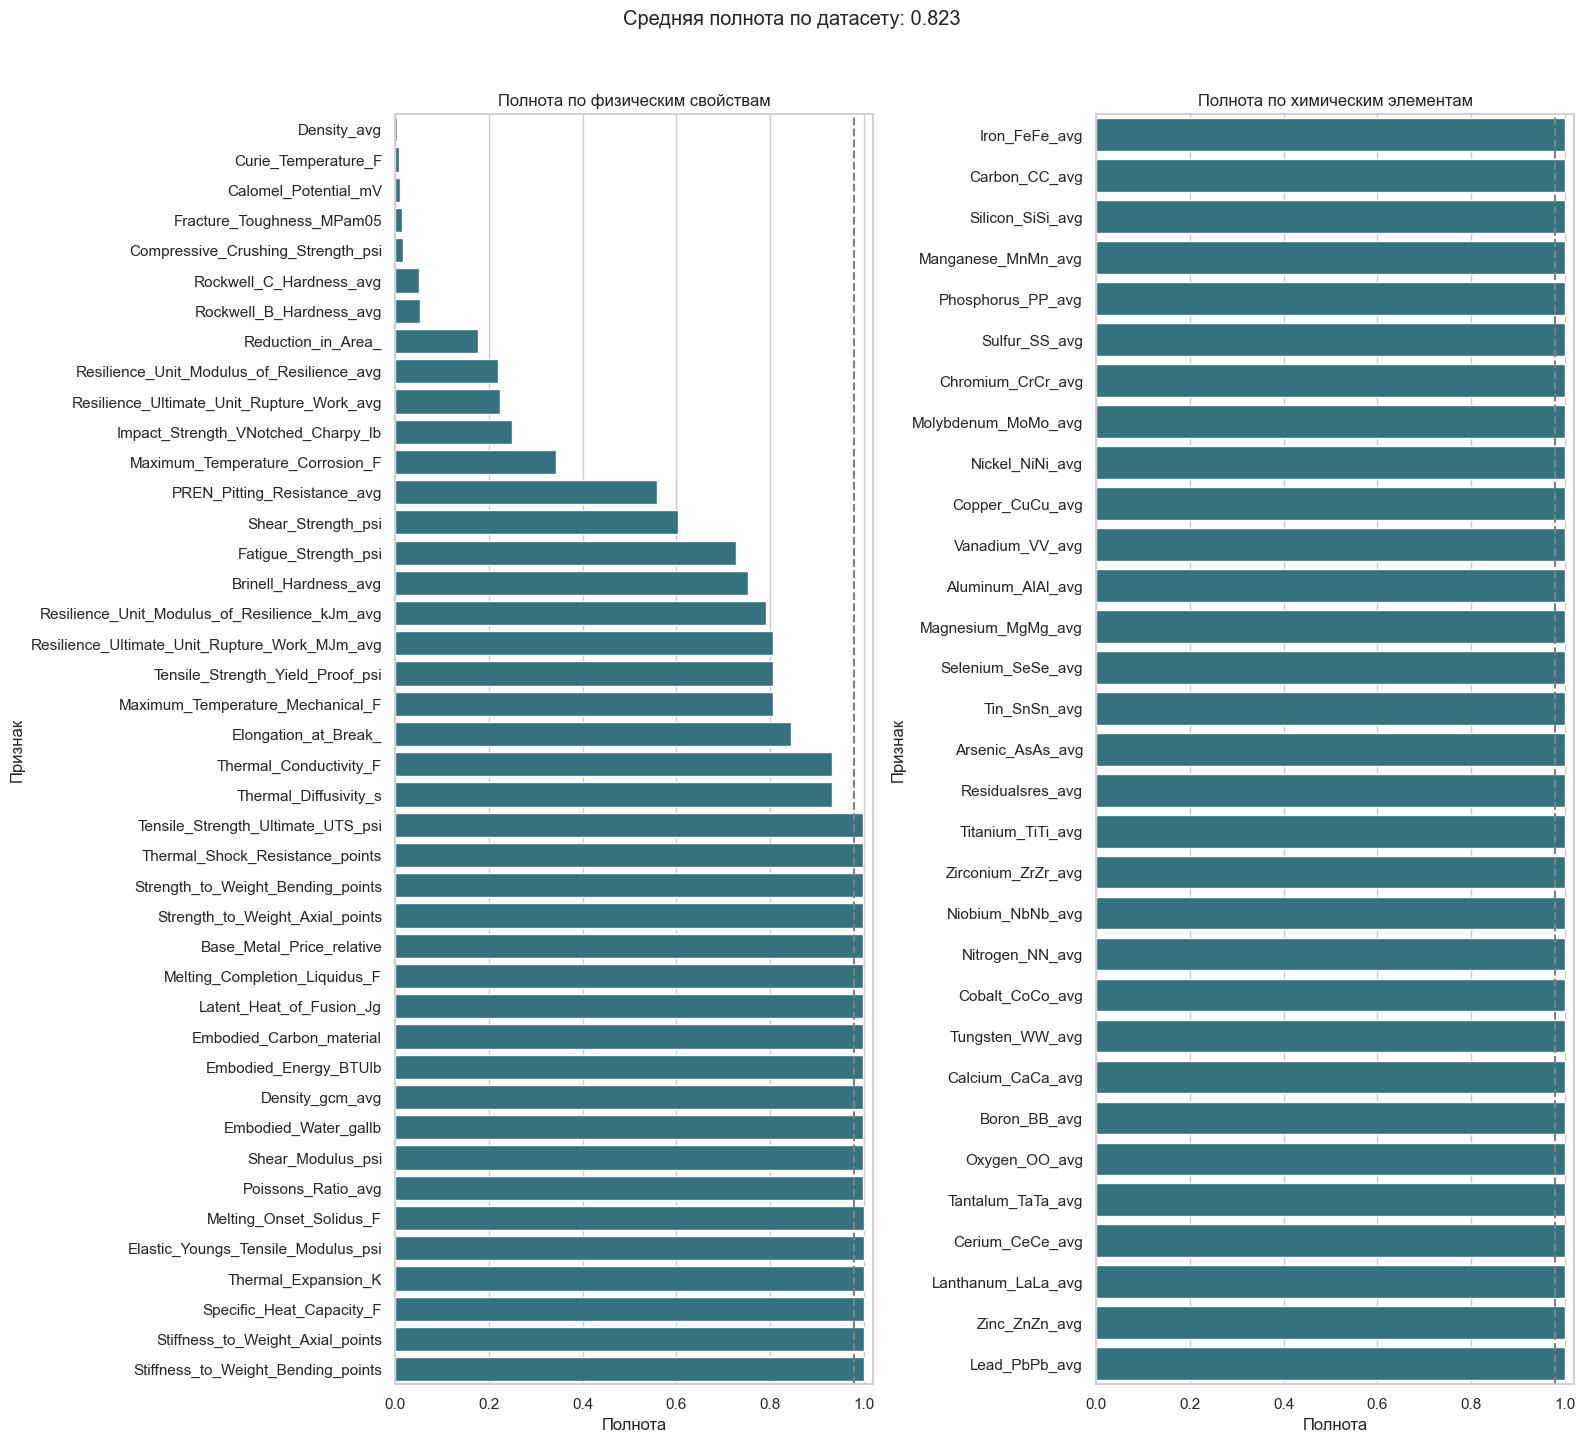

In [20]:
def compute_completeness(
    df_out: pd.DataFrame,
) -> Tuple[pd.DataFrame, pd.Series, float]:
    print("Дубликаты строк (до очистки):", df_out.duplicated().sum())
    df_clean = df_out.drop_duplicates()
    print("Дубликаты строк (после очистки):", df_clean.duplicated().sum())

    completeness = 1 - df_clean.isna().mean()
    print("Полнота данных (1 - NaN), по столбцам:")
    print(completeness.round(3))

    avg_completeness = float(completeness.mean().round(3))
    return df_clean, completeness, avg_completeness


def make_comp_df(completeness: pd.Series, cols: list) -> pd.DataFrame:
    # Сортируем по возрастанию
    if not cols:
        return pd.DataFrame({"feature": [], "completeness": []})

    comp = completeness[cols].sort_values(ascending=True).reset_index()
    comp.columns = ["feature", "completeness"]
    return comp


def plot_side_by_side(
    comp_phys: pd.DataFrame, comp_chem: pd.DataFrame, avg_completeness: float
) -> None:
    # Строим два барграфа - один по физическим свойствам, а второй по химическим
    sns.set_theme(style="whitegrid")
    bar_color = sns.color_palette("crest", 6)[3]

    n_bars = max(len(comp_phys), len(comp_chem), 1)
    fig_height = max(6, 0.35 * n_bars)
    fig, axes = plt.subplots(1, 2, figsize=(16, fig_height), sharex=True)

    sns.barplot(
        data=comp_phys,
        x="completeness",
        y="feature",
        color=bar_color,
        ax=axes[0],
    )
    axes[0].axvline(0.98, linestyle="--", color="gray")
    axes[0].set_title("Полнота по физическим свойствам")
    axes[0].set_xlabel("Полнота")
    axes[0].set_ylabel("Признак")

    sns.barplot(
        data=comp_chem,
        x="completeness",
        y="feature",
        color=bar_color,
        ax=axes[1],
    )
    axes[1].axvline(0.98, linestyle="--", color="gray")
    axes[1].set_title("Полнота по химическим элементам")
    axes[1].set_xlabel("Полнота")
    axes[1].set_ylabel("Признак")

    axes[0].set_xlim(0, 1.02)
    axes[1].set_xlim(0, 1.02)
    plt.suptitle(f"Средняя полнота по датасету: {avg_completeness:.3f}", y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def run_plot(
    df_out: pd.DataFrame, alloy_name_col: str = "iron_alloy_name"
) -> Tuple[pd.DataFrame, pd.Series, float, list, list]:
    df_clean, completeness, avg = compute_completeness(df_out)
    phys_cols, chem_cols = split_columns(df_clean, alloy_name_col=alloy_name_col)
    comp_phys = make_comp_df(completeness, phys_cols)
    comp_chem = make_comp_df(completeness, chem_cols)
    plot_side_by_side(comp_phys, comp_chem, avg)
    return df_clean, completeness, avg, phys_cols, chem_cols


df_clean, completeness, avg, phys_cols, chem_cols = run_plot(df_out)

Дубликаты строк были удалены. Во многих физических свойствах сплавов большое количество пропусков, что ожидаемо для реальных экспериментальных данных. Химический состав же для каждого сплава записан полностью, так как ранее пропуски были обработаны. Средняя полнота 0.836. 

# Оценка выбросов
Оценивать выбросы будем по физическим свойствам сплавов.

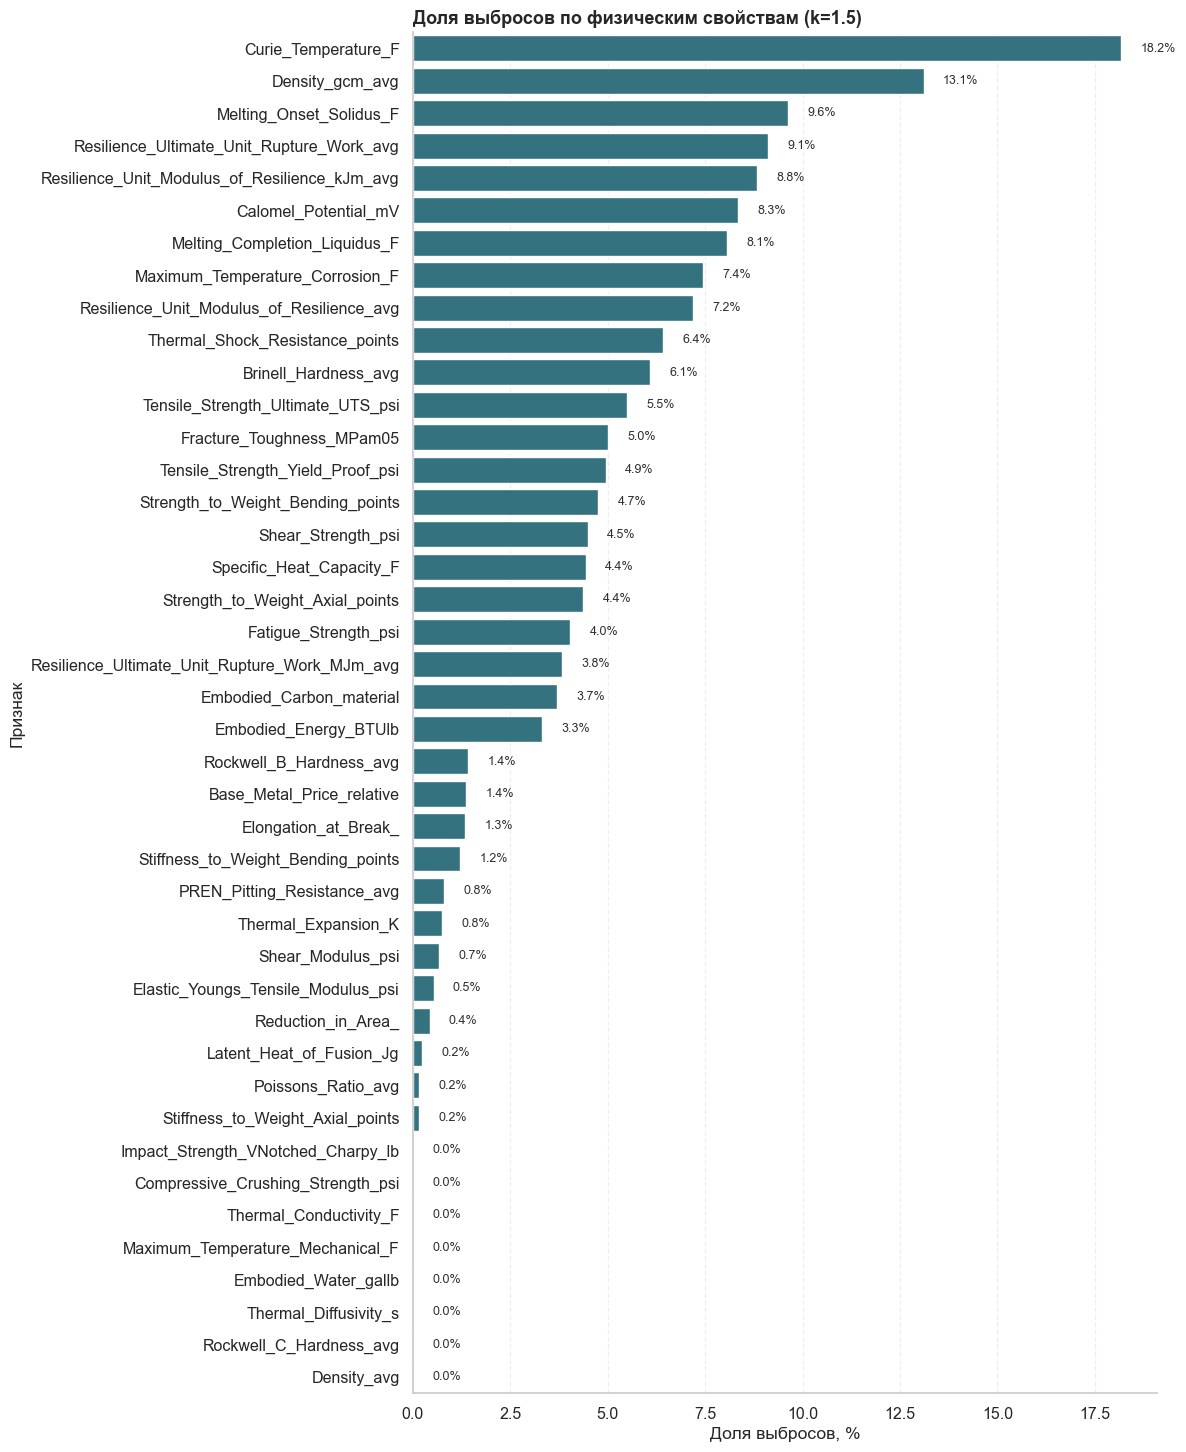

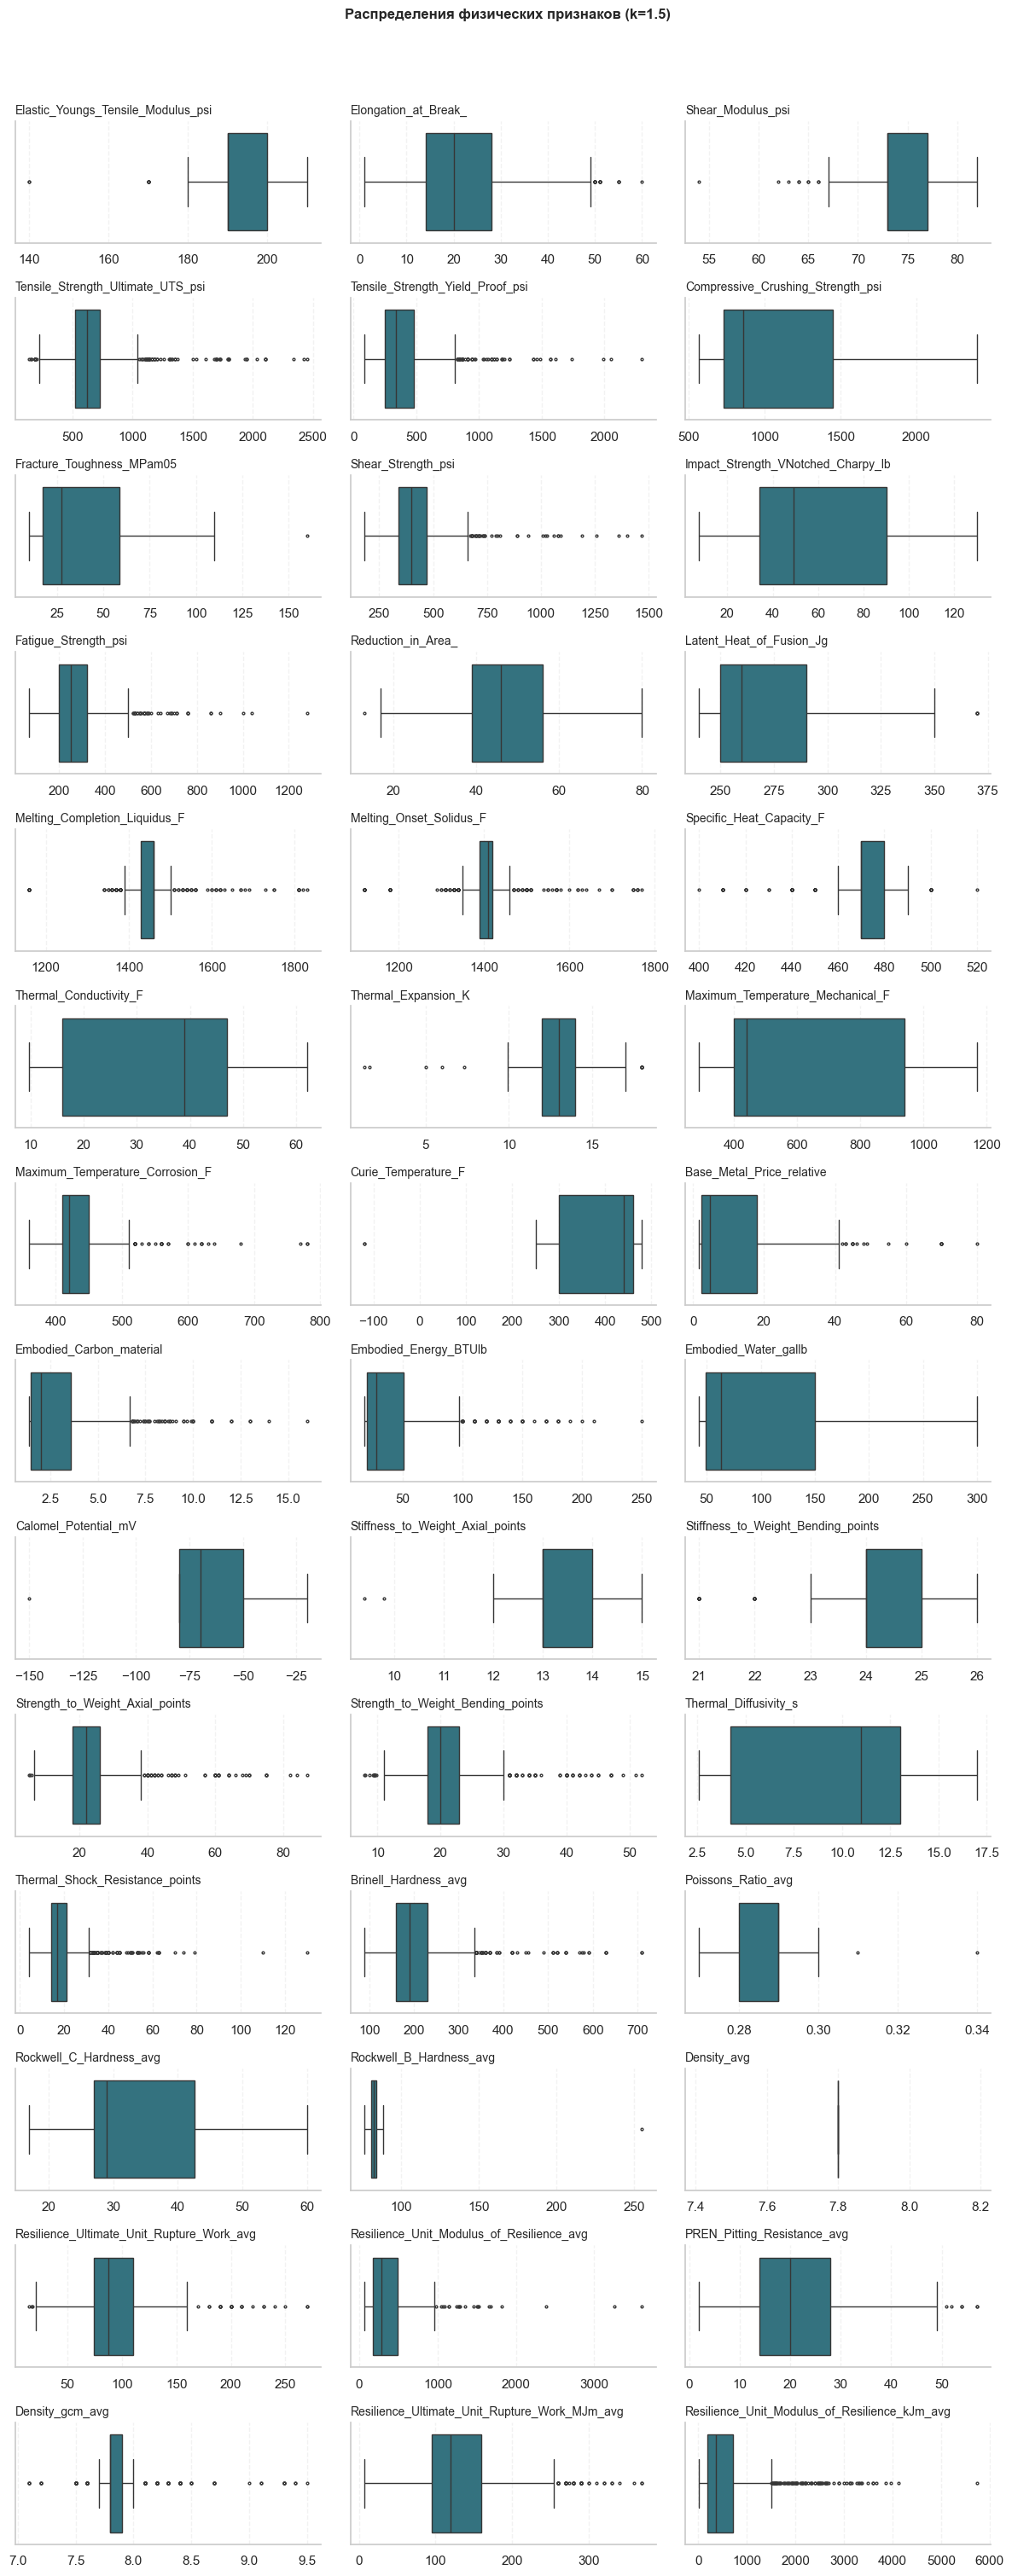

,min,max,q1,q3,iqr,lower,upper,outliers,out_%
Elastic_Youngs_Tensile_Modulus_psi,140.00,210.00,190.00,200.00,10.00,175.00,215.00,7.00,0.53
Elongation_at_Break_,1.00,60.00,14.00,28.00,14.00,-7.00,49.00,15.00,1.34
Shear_Modulus_psi,54.00,82.00,73.00,77.00,4.00,67.00,83.00,9.00,0.68
Tensile_Strength_Ultimate_UTS_psi,140.00,2450.00,520.00,730.00,210.00,205.00,1045.00,73.00,5.50
Tensile_Strength_Yield_Proof_psi,84.00,2300.00,250.00,480.00,230.00,-95.00,825.00,53.00,4.94
Compressive_Crushing_Strength_psi,570.00,2400.00,730.00,1450.00,720.00,-350.00,2530.00,0.00,0.00
Fracture_Toughness_MPam05,10.00,160.00,17.25,58.50,41.25,-44.62,120.38,1.00,5.00
Shear_Strength_psi,180.00,1470.00,340.00,470.00,130.00,145.00,665.00,36.00,4.48
Impact_Strength_VNotched_Charpy_lb,7.60,130.00,34.00,90.00,56.00,-50.00,174.00,0.00,0.00
Fatigue_Strength_psi,69.00,1280.00,200.00,320.00,120.00,20.00,500.00,39.00,4.04


In [21]:
def iqr_stats(s: pd.Series, k: float = 1.5) -> pd.Series:
    # Определяем выбросы методом IQR
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lb, ub = q1 - k * iqr, q3 + k * iqr

    # Значения внутри интервала и NaN не считаем выбросами
    mask_in = s.between(lb, ub) | s.isna()
    outliers = (~mask_in).sum()
    denom = s.notna().sum()
    out_percent = (outliers / denom * 100) if denom > 0 else 0.0

    return pd.Series(
        {
            "min": s.min(),
            "max": s.max(),
            "q1": q1,
            "q3": q3,
            "iqr": iqr,
            "lower": lb,
            "upper": ub,
            "outliers": int(outliers),
            "out_%": out_percent,
        }
    )


def compute_iqr_table_for_phys(
    df_clean: pd.DataFrame,
    phys_cols: list,
    k: float = 1.5,
) -> pd.DataFrame:
    out_df = df_clean[phys_cols].apply(lambda s: iqr_stats(s, k=k)).T
    cols_order = ["min", "max", "q1", "q3", "iqr", "lower", "upper", "outliers", "out_%"]
    out_df = out_df[cols_order]
    return out_df


def plot_outlier_rate_bar(
    out_df: pd.DataFrame,
    title: str,
    palette_name: str = "crest",
) -> None:
    sns.set_theme(style="whitegrid", font_scale=1.05)
    color = sns.color_palette(palette_name, 6)[3]

    plot_df = out_df.reset_index().rename(columns={"index": "feature"})
    plot_df = plot_df.sort_values("out_%", ascending=False)

    fig_height = max(4, 0.35 * len(plot_df))
    fig, ax = plt.subplots(figsize=(12, fig_height))

    sns.barplot(data=plot_df, x="out_%", y="feature", color=color, ax=ax)

    ax.set_title(title, loc="left", fontsize=13, weight="bold")
    ax.set_xlabel("Доля выбросов, %")
    ax.set_ylabel("Признак")
    ax.grid(axis="x", linestyle="--", alpha=0.3)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    for p in ax.patches:
        w = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.text(
            w + 0.5,
            y,
            f"{w:.1f}%",
            va="center",
            ha="left",
            fontsize=9,
            color="#2f2f2f",
        )

    plt.tight_layout()
    plt.show()


def plot_phys_box_grid(
    df_clean: pd.DataFrame,
    phys_cols: list,
    k: float = 1.5,
    ncols: int = 3,
    palette_name: str = "crest",
    title: str = "Распределения физических признаков",
) -> None:
    sns.set_theme(style="whitegrid", font_scale=1.0)
    color = sns.color_palette(palette_name, 6)[3]

    n = len(phys_cols)
    rows = math.ceil(n / ncols)
    fig_height = max(6, 2.2 * rows)
    fig_width = max(10, 4 * ncols)
    fig, axes = plt.subplots(rows, ncols, figsize=(fig_width, fig_height), squeeze=False)

    idx = 0
    for r in range(rows):
        for c in range(ncols):
            ax = axes[r][c]
            if idx < n:
                col = phys_cols[idx]
                sns.boxplot(x=df_clean[col], color=color, ax=ax, whis=k, fliersize=2)
                ax.set_title(col, fontsize=10, loc="left")
                ax.set_xlabel("")
                ax.set_ylabel("")
                ax.grid(axis="x", linestyle="--", alpha=0.25)
                for spine in ["top", "right"]:
                    ax.spines[spine].set_visible(False)
            else:
                ax.axis("off")
            idx += 1

    plt.suptitle(title + f" (k={k})", y=0.98, fontsize=12, weight="semibold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def run_physical_iqr(
    df_clean: pd.DataFrame,
    phys_cols: list,
    k: float = 1.5,
    ncols: int = 3,
) -> pd.DataFrame:
    df_phys_iqr = compute_iqr_table_for_phys(df_clean, phys_cols, k=k)
    plot_outlier_rate_bar(
        df_phys_iqr,
        title=f"Доля выбросов по физическим свойствам (k={k})",
    )
    plot_phys_box_grid(df_clean, phys_cols, k=k, ncols=ncols)
    return df_phys_iqr


df_phys_iqr = run_physical_iqr(df_clean, phys_cols, k=1.5, ncols=3)
display(df_phys_iqr.style.format("{:.2f}"))

Относительно физических свойств: анализ показал, что присутствуют колонки с разным процентом выбросов. Во многих из них он довольно высок (н-р, Curie Temperature (F) 18.18%). Выбросы среди физических свойств сплавов следует рассматривать очень тщательно, беря во внимания их состав. Некоторые сплавы действительно могут показывать сильные отличия в физ свойствах, в зависимости от своего состава. Но также существует вероятность и экспериментальной/приборной ошибки. В общем, каждый такой случай должен рассматриваться отдельно.

# Корреляция между числовыми признаками

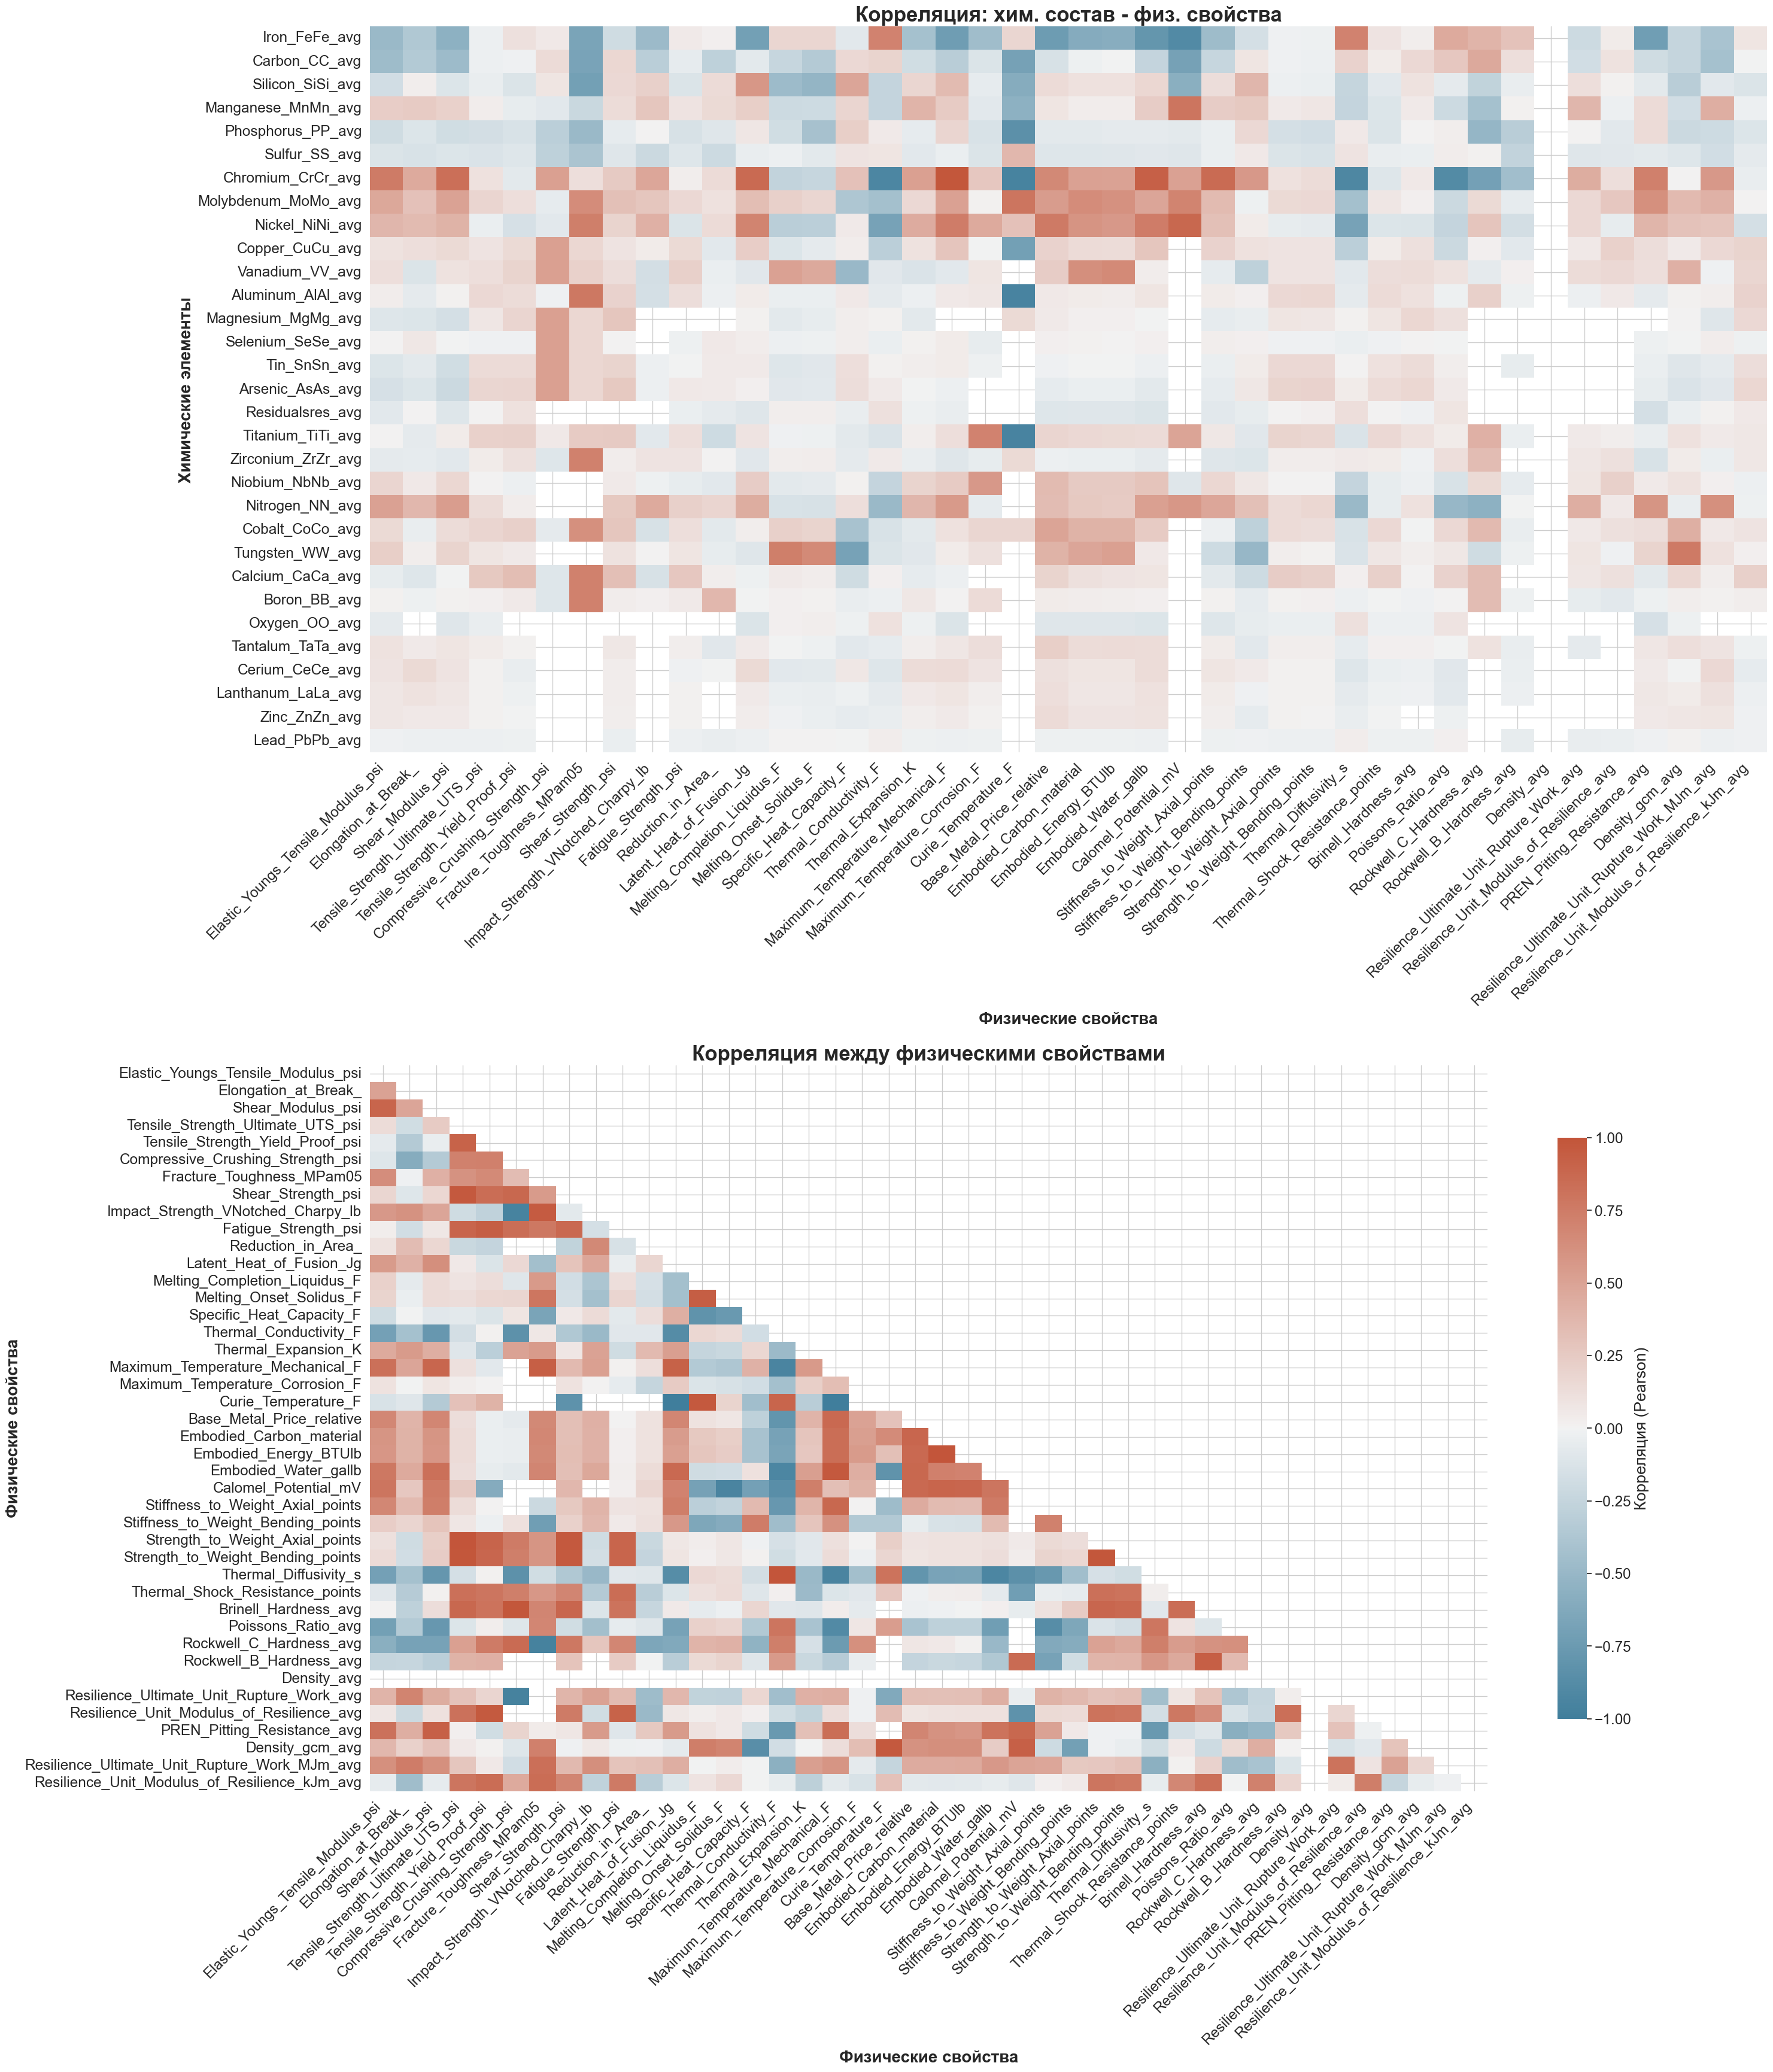

In [22]:
def plot_correlation_maps(
    df_clean: pd.DataFrame,
    phys_cols: list,
    chem_cols: list,
    method: str = "pearson",
    annotate: bool = False,
    mask_upper_phys: bool = True,
    figsize: tuple = (30, 35),
    hspace: float = 0.25,  # параметр для управления вертикальным зазором
) -> None:
    sns.set_theme(style="whitegrid", font_scale=1.6)

    # Общая корреляционная матрица и срезы
    all_cols = list(chem_cols) + list(phys_cols)
    corr_all = df_clean[all_cols].corr(numeric_only=True, method=method)
    corr_chem_phys = corr_all.loc[chem_cols, phys_cols]
    corr_phys_phys = corr_all.loc[phys_cols, phys_cols]

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    fig.subplots_adjust(hspace=hspace)

    # Верхний график хим состав - физ свойство
    ax_top = axes[0]
    sns.heatmap(
        corr_chem_phys,
        ax=ax_top,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        annot=annotate,
        fmt=".2f" if annotate else "",
        cbar=False,
    )
    ax_top.set_title(
        "Корреляция: хим. состав - физ. свойства",
        fontsize=25,
        fontweight="bold",
    )
    ax_top.set_xlabel("Физические свойства", fontsize=20, fontweight="bold")
    ax_top.set_ylabel("Химические элементы", fontsize=20, fontweight="bold")
    plt.setp(ax_top.get_xticklabels(), rotation=45, ha="right")
    plt.setp(ax_top.get_yticklabels(), rotation=0)

    # Нижний график физ св-во - физ св-во
    ax_bottom = axes[1]
    mask = (
        np.triu(np.ones_like(corr_phys_phys, dtype=bool))
        if (mask_upper_phys and corr_phys_phys.shape[0] >= 2)
        else None
    )
    sns.heatmap(
        corr_phys_phys,
        ax=ax_bottom,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        annot=annotate,
        fmt=".2f" if annotate else "",
        mask=mask,
        cbar=True,
        cbar_kws={"shrink": 0.8, "label": f"Корреляция ({method.title()})"},
    )
    ax_bottom.set_title(
        "Корреляция между физическими свойствами",
        fontsize=25,
        fontweight="bold",
    )
    ax_bottom.set_xlabel("Физические свойства", fontsize=20, fontweight="bold")
    ax_bottom.set_ylabel("Физические свойства", fontsize=20, fontweight="bold")
    plt.setp(ax_bottom.get_xticklabels(), rotation=45, ha="right")
    plt.setp(ax_bottom.get_yticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()


plot_correlation_maps(
    df_clean,
    phys_cols,
    chem_cols,
    method="pearson",
    annotate=False,
    mask_upper_phys=True,
    figsize=(30, 35),
)

На верхней тепловой карте отражены корреляции физических свойств относительно хим состава. Это позволяет выявить, какие химические элементы, входящие в состав сплава наиболее сильно влияют на его физические свойства, чтобы в дальнейшем выявлять признаки для варьирования при синтезе. Снизу тепловая карта, отражающая корреляции между физическими свойствами, что можно использовать в дальнейшем для исключения избыточных признаков.

В качестве примера рассмотрим зависимость признаков Maximum Tempriture Mechanical (максимальную температуру, при которой материал сохраняет свои механические свойства) и Thermal Conductivity от содержания хрома в образцах сплава.

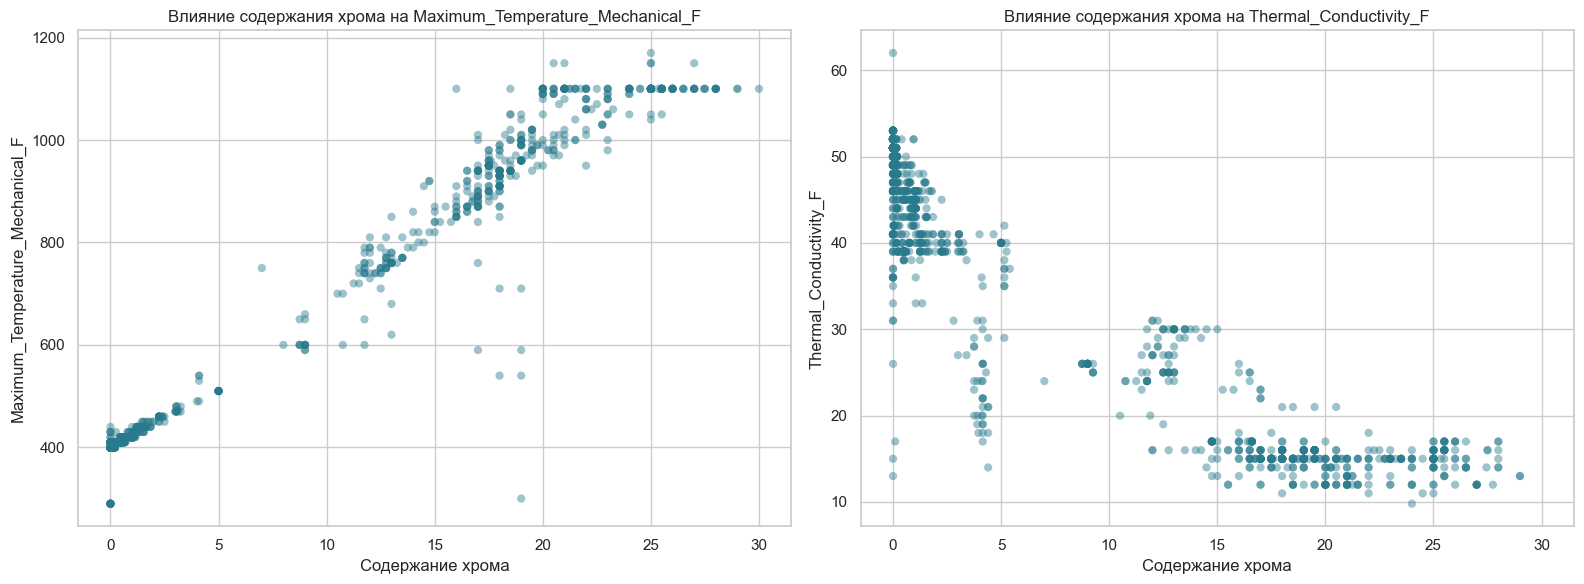

In [23]:
def plot_chromium_two_targets_scatter(
    df: pd.DataFrame,
    chromium_col: str = "Chromium_CrCr_avg",
    left_target: str = "Maximum_Temperature_Mechanical_F",
    right_target: str = "Thermal_Conductivity_F",
    figsize: tuple = (16, 6),
    scatter_alpha: float = 0.45,
    scatter_size: int = 35,
    remove_edge: bool = True,
) -> None:
    # Два графика: Maximum_Temperature_Mechanical_F и Thermal_Conductivity_F от содержания хрома
    sub_left = df[[chromium_col, left_target]].dropna()
    sub_right = df[[chromium_col, right_target]].dropna()

    sns.set_theme(style="whitegrid")
    point_color = sns.color_palette("crest", 6)[3]

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)

    # Левый график: Maximum_Temperature_Mechanical_F
    ax_left = axes[0]
    sns.scatterplot(
        data=sub_left,
        x=chromium_col,
        y=left_target,
        color=point_color,
        alpha=scatter_alpha,
        s=scatter_size,
        edgecolor="none" if remove_edge else None,
        ax=ax_left,
    )
    ax_left.set_title(f"Влияние содержания хрома на {left_target}")
    ax_left.set_xlabel("Содержание хрома")
    ax_left.set_ylabel(left_target)

    # Правый график: Thermal_Conductivity_F
    ax_right = axes[1]
    sns.scatterplot(
        data=sub_right,
        x=chromium_col,
        y=right_target,
        color=point_color,
        alpha=scatter_alpha,
        s=scatter_size,
        edgecolor="none" if remove_edge else None,
        ax=ax_right,
    )
    ax_right.set_title(f"Влияние содержания хрома на {right_target}")
    ax_right.set_xlabel("Содержание хрома")
    ax_right.set_ylabel(right_target)

    plt.tight_layout()
    plt.show()


plot_chromium_two_targets_scatter(
    df_clean,
    chromium_col="Chromium_CrCr_avg",
    left_target="Maximum_Temperature_Mechanical_F",
    right_target="Thermal_Conductivity_F",
    figsize=(16, 6),
    scatter_alpha=0.45,
    scatter_size=35,
    remove_edge=True,
)

На графиках выше видно, что увеличение содержание хрома в сплаве приводит к увеличению максимальной темпеературы, при которой материал сохраняет свои механические свойств, и наоборот, приводит к уменьшению термической проводимости.

# Выводы
1. Датасет содержит 115 количественных признаков. Многие признаки представлены в виде набора "макс/мин", для многих приложений будет удобно усреднить эти столбцы для сокращения количества признаков.
2. Процент пропущенных значений по некоторым столбцам довольно велик, что говорит о необходимости поиска пропущенных значений в публикациях (или проведения исследований, если они не опубликованы). Средняя полнота 0.836, что меньше, чем 0.98, и поэтому является не очень хорошим значением, но довольно ожидаемым для реальных экспериментальных данных.
3. Дубликаты строк были удалены.
4. Исследование выбросов показало присутствие их большого количества во многих колонках, представляющих физические свойства сплавов. Случаи таких выбросов требуют отдельного внимания, каждый случай требует более глубокого анализа.
5. Корреляционный анализ показал завимости между химическим составом сплава и его физическими свойствами, что можно применять для подбора состава сплава, обладающего заданными физическими свойствами. Многие физические свойства также коррелируют, такие зависимости важно знать при выборе важных признаков для построения моделей.